In [24]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [26]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [27]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [28]:
tf.keras.backend.clear_session()

In [29]:
subject = 'Bahia - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [30]:
data = pd.read_csv('2003_mo_model_input_BA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Bahia - value,Bahia- custo m2 (R$),Bahia - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.299858,10915.348400,151.297,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,0.766362,0.669899,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.301903,11028.218400,138.707,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,0.766745,0.670210,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.303709,11133.335807,135.009,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,0.767127,0.670521,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.305311,11215.137236,126.554,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,0.767509,0.670831,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.306860,11294.955512,137.331,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,0.767892,0.671142,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,1.608320,1010.371607,1488.966218,24.817842,20.666681,78.229336,1.977754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2002-9,NaN,NaN,NaN,1.453784,1009.628033,1569.704039,25.399925,20.932220,76.934612,2.093929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2002-10,NaN,NaN,NaN,1.071670,1008.927909,1667.519304,26.035253,21.204426,75.331548,2.191347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2002-11,NaN,NaN,NaN,1.149319,1008.388051,1694.210509,26.573861,21.523948,74.405966,2.307342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


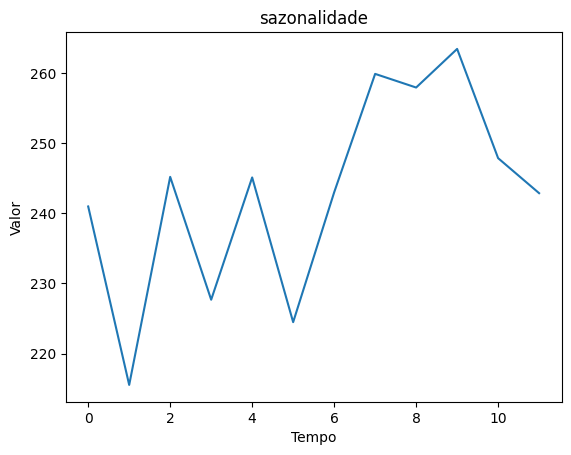

,sazonalidade
sazonalidade,
0,240.981090
1,215.539900
2,245.202066
3,227.688361
4,245.118647
5,224.488539
6,242.991489
7,259.883879
8,257.939056


In [31]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [32]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Bahia - Consumo de Cimento (t)
0,2003-1,0.299858,10915.348400,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,0.766362,0.669899,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,240.981090,151.297
1,2003-2,0.301903,11028.218400,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,0.766745,0.670210,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,215.539900,138.707
2,2003-3,0.303709,11133.335807,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,0.767127,0.670521,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,245.202066,135.009
3,2003-4,0.305311,11215.137236,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,0.767509,0.670831,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,227.688361,126.554
4,2003-5,0.306860,11294.955512,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,0.767892,0.671142,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,245.118647,137.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,1.608320,1010.371607,1488.966218,24.817842,20.666681,78.229336,1.977754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.118647,NaN
269,2002-9,NaN,NaN,1.453784,1009.628033,1569.704039,25.399925,20.932220,76.934612,2.093929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.488539,NaN
270,2002-10,NaN,NaN,1.071670,1008.927909,1667.519304,26.035253,21.204426,75.331548,2.191347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.991489,NaN
271,2002-11,NaN,NaN,1.149319,1008.388051,1694.210509,26.573861,21.523948,74.405966,2.307342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.883879,NaN


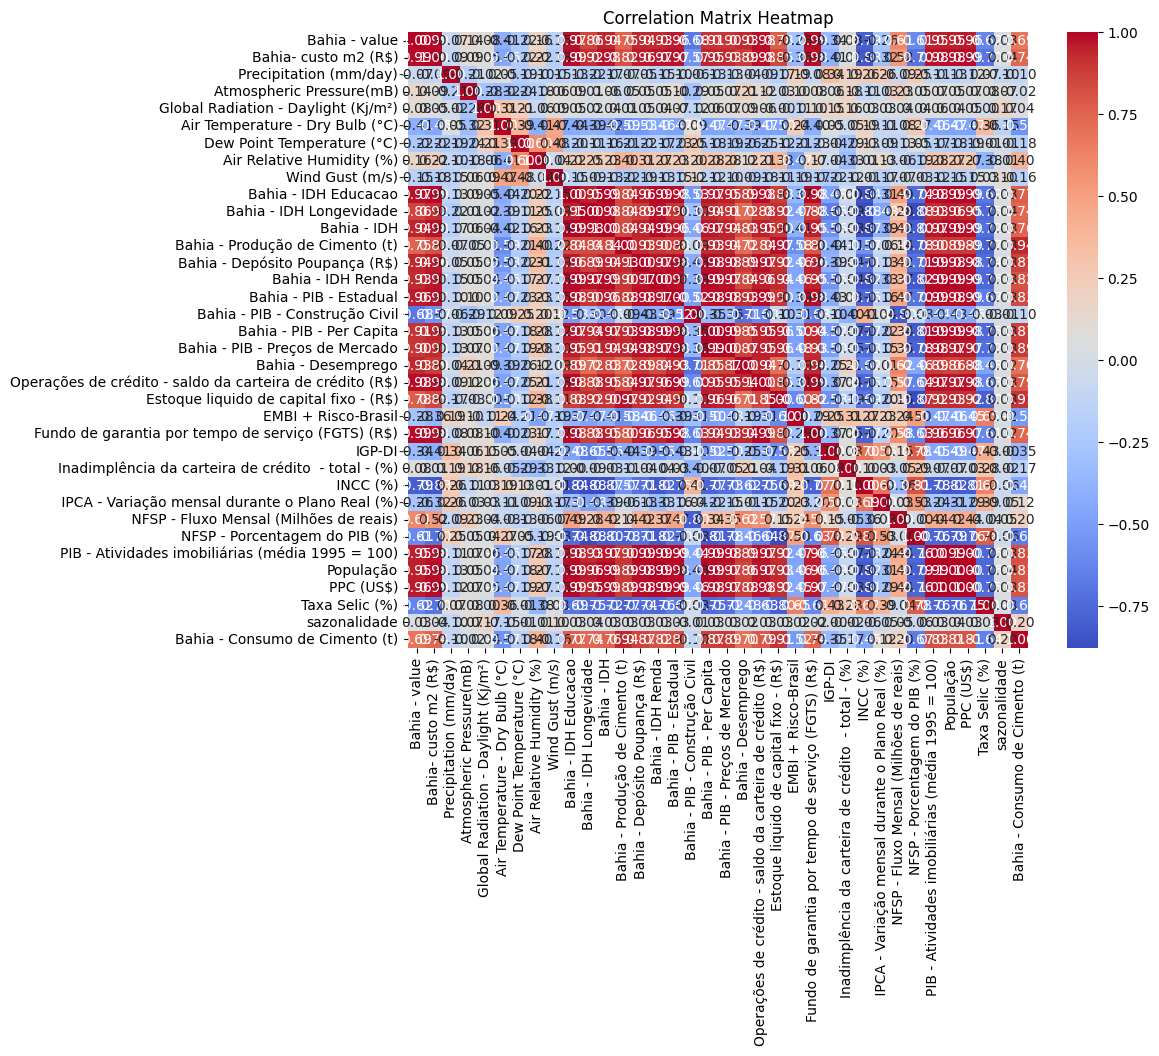

In [33]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [34]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [35]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.440329,-1.671449,-0.038360,-0.693716,1.240513,0.642079,0.029035,-0.182257,1.402525,-1.848551,-2.549555,-2.143224,-1.723080,-1.584098,-2.149391,-1.703176,-0.816345,-2.235724,-2.158201,-0.884052,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-0.134088
1,-1.404914,-1.644714,1.221742,-0.603174,0.710245,0.432351,0.060353,0.138191,0.499197,-1.825983,-2.497686,-2.108465,-1.735985,-1.574477,-2.116918,-1.684201,-0.772933,-2.194204,-2.117854,-0.885724,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.974093
2,-1.373637,-1.619815,1.400094,-0.351990,0.098880,0.069766,0.033064,0.452705,-0.356839,-1.803414,-2.445817,-2.073707,-1.739214,-1.564855,-2.084445,-1.665225,-0.729522,-2.152684,-2.077508,-0.887395,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,0.171189
3,-1.345888,-1.600440,1.441606,0.189583,-0.389576,-0.373005,-0.109968,0.516308,-1.154465,-1.780846,-2.393948,-2.038948,-1.738529,-1.555234,-2.051972,-1.646249,-0.686111,-2.111164,-2.037161,-0.889067,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.095469
4,-1.319065,-1.581534,1.224400,0.717316,-0.743902,-0.885415,-0.250986,0.669955,-1.755788,-1.758277,-2.342079,-2.004190,-1.735989,-1.545612,-2.019499,-1.627274,-0.642700,-2.069645,-1.996814,-0.890739,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.165156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.796141,1.727528,-0.479209,0.697302,-0.057929,-0.798014,-0.498914,-0.113596,-0.437518,1.367030,0.984883,1.261516,0.511535,1.225571,1.109537,1.096947,-1.668064,0.877256,0.724962,1.200853,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.233035
188,1.811284,1.753086,0.014731,0.264175,0.241939,-0.526252,-0.419733,-0.176406,-0.385163,1.365214,0.962848,1.253736,0.513264,1.232652,1.096596,1.085441,-1.663847,0.851021,0.704849,1.200487,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.092378
189,1.833479,1.782312,0.024464,0.049785,0.693616,-0.151337,-0.321149,-0.283086,-0.415774,1.363397,0.940812,1.245956,0.526782,1.239733,1.083655,1.073935,-1.659631,0.824786,0.684737,1.200122,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.490427
190,1.853109,1.814876,-0.195334,-0.223773,1.086440,0.283656,-0.205138,-0.406765,-0.475393,1.361580,0.918777,1.238176,0.525379,1.246815,1.070714,1.062429,-1.655414,0.798552,0.664624,1.199756,1.370978,0.332791,-0.169867,1.654237

In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      129.857
1      126.813
2      152.225
3      136.288
4      148.117
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Bahia - Consumo de Cimento (t), Length: 273, dtype: float64

In [37]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.440329,-1.671449,-0.038360,-0.693716,1.240513,0.642079,0.029035,-0.182257,1.402525,-1.848551,-2.549555,-2.143224,-1.723080,-1.584098,-2.149391,-1.703176,-0.816345,-2.235724,-2.158201,-0.884052,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-0.134088
1,-1.404914,-1.644714,1.221742,-0.603174,0.710245,0.432351,0.060353,0.138191,0.499197,-1.825983,-2.497686,-2.108465,-1.735985,-1.574477,-2.116918,-1.684201,-0.772933,-2.194204,-2.117854,-0.885724,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.974093
2,-1.373637,-1.619815,1.400094,-0.351990,0.098880,0.069766,0.033064,0.452705,-0.356839,-1.803414,-2.445817,-2.073707,-1.739214,-1.564855,-2.084445,-1.665225,-0.729522,-2.152684,-2.077508,-0.887395,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,0.171189
3,-1.345888,-1.600440,1.441606,0.189583,-0.389576,-0.373005,-0.109968,0.516308,-1.154465,-1.780846,-2.393948,-2.038948,-1.738529,-1.555234,-2.051972,-1.646249,-0.686111,-2.111164,-2.037161,-0.889067,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.095469
4,-1.319065,-1.581534,1.224400,0.717316,-0.743902,-0.885415,-0.250986,0.669955,-1.755788,-1.758277,-2.342079,-2.004190,-1.735989,-1.545612,-2.019499,-1.627274,-0.642700,-2.069645,-1.996814,-0.890739,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.165156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.097864,1.097398,-0.463180,-0.124526,0.716001,0.740382,-0.089711,-0.552869,-0.500043,1.377660,1.460539,1.430739,0.617097,0.815243,1.280030,1.205171,-1.332406,1.004714,1.051323,1.273469,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.974093
158,1.120412,1.117123,-0.366119,0.218896,0.134174,0.476543,-0.138090,-0.420868,-0.369291,1.377535,1.449245,1.428086,0.590103,0.827342,1.271980,1.206522,-1.357999,1.007770,1.045502,1.268173,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,0.171189
159,1.139591,1.137362,-0.415933,0.632077,-0.347743,0.001694,-0.258235,-0.273422,-0.389089,1.377409,1.437951,1.425433,0.561454,0.839442,1.263929,1.207873,-1.383592,1.010826,1.039682,1.262877,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-1.095469
160,1.156903,1.154862,-0.184106,1.099938,-0.659225,-0.480778,-0.393645,-0.149855,-0.325560,1.377283,1.426657,1.422780,0.523492,0.851541,1.255878,1.209225,-1.409185,1.013881,1.033862,1.257581,1.306664,0.785801,1.017171,1.240363,-1.

In [38]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      129.857
1      126.813
2      152.225
3      136.288
4      148.117
        ...   
157    213.266
158    285.938
159    219.576
160    267.203
161    240.714
Name: Bahia - Consumo de Cimento (t), Length: 162, dtype: float64

In [39]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [40]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [41]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.558660,0.467576,0.398433,0.532679,-0.668258,-1.288408,-0.301039,0.974067,-0.100403,0.540328,0.348354,0.461215,1.205505,1.056196,0.727414,0.833268,0.194482,0.840990,1.014636,0.957509,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.011312
127,0.586295,0.485932,0.881864,0.430146,-0.313819,-1.213327,-0.305019,0.883592,0.125796,0.557903,0.342681,0.471044,1.203037,1.078359,0.721238,0.852943,0.147537,0.856945,1.027926,0.975019,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,1.233035
128,0.614441,0.504868,1.489586,0.052429,-0.053698,-0.954125,-0.212853,0.871901,0.231163,0.575478,0.337008,0.480874,1.178322,1.100522,0.715062,0.872618,0.100591,0.872900,1.041216,0.992528,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,1.092378
129,0.639726,0.524071,1.573881,-0.261929,0.254958,-0.665839,-0.129927,0.796449,0.231164,0.593053,0.331335,0.490704,1.155459,1.122685,0.708886,0.892293,0.053646,0.888855,1.054506,1.010038,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.490427
130,0.666428,0.542675,1.385770,-0.590265,0.532349,-0.411419,-0.036978,0.790608,0.097551,0.610629,0.325662,0.500533,1.124580,1.144848,0.702709,0.911968,0.006700,0.904809,1.067796,1.027547,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.364041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.796141,1.727528,-0.479209,0.697302,-0.057929,-0.798014,-0.498914,-0.113596,-0.437518,1.367030,0.984883,1.261516,0.511535,1.225571,1.109537,1.096947,-1.668064,0.877256,0.724962,1.200853,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.233035
188,1.811284,1.753086,0.014731,0.264175,0.241939,-0.526252,-0.419733,-0.176406,-0.385163,1.365214,0.962848,1.253736,0.513264,1.232652,1.096596,1.085441,-1.663847,0.851021,0.704849,1.200487,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.092378
189,1.833479,1.782312,0.024464,0.049785,0.693616,-0.151337,-0.321149,-0.283086,-0.415774,1.363397,0.940812,1.245956,0.526782,1.239733,1.083655,1.073935,-1.659631,0.824786,0.684737,1.200122,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.490427
190,1.853109,1.814876,-0.195334,-0.223773,1.086440,0.283656,-0.205138,-0.406765,-0.475393,1.361580,0.918777,1.238176,0.525379,1.246815,1.070714,1.062429,-1.655414,0.798552,0.664624,1.199756,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1

In [42]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [43]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [44]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=100, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=20)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True, 
                                      input_shape=(train_input.shape[1], train_input.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                        train_target, 
                        epochs=200,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [45]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][20:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [46]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3276593520, 853984725, 245707845, 210665373, 682795746, 1628895984, 3689525599, 2933523788, 253862587, 1346981268]


Step: 0 ___________________________________________


2023-10-22 11:33:47.099271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 11:33:47.099462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 11:33:47.099604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 537.95947265625
winner_seed: 3276593520


Step: 1 ___________________________________________
val_loss: 404.5072021484375
winner_seed: 853984725


Step: 2 ___________________________________________
val_loss: 520.802978515625


Step: 3 ___________________________________________
val_loss: 629.6521606445312


Step: 4 ___________________________________________
val_loss: 394.9695129394531
winner_seed: 682795746


Step: 5 ___________________________________________
val_loss: 422.84429931640625


Step: 6 ___________________________________________
val_loss: 272.66943359375
winner_seed: 3689525599


Step: 7 ___________________________________________
val_loss: 365.6938781738281


Step: 8 ___________________________________________
val_loss: 536.9913330078125


Step: 9 ___________________________________________
val_loss: 462.9783020019531


final_seed: 3689525599


In [53]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2536234443

Epoch 1/200
4/4 [==============================] - 2s 111ms/step - loss: 71698.5547 - val_loss: 47652.8203
Epoch 2/200
4/4 [==============================] - 0s 8ms/step - loss: 11314.9082 - val_loss: 1081.8778
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 2007.1820 - val_loss: 1780.9735
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 1459.7572 - val_loss: 2443.6289
Epoch 5/200
4/4 [==============================] - 0s 8ms/step - loss: 1154.1201 - val_loss: 1696.5416
Epoch 6/200
4/4 [==============================] - 0s 8ms/step - loss: 967.8608 - val_loss: 2604.6174
Epoch 7/200
4/4 [==============================] - 0s 7ms/step - loss: 926.4102 - val_loss: 2137.2988
Epoch 8/200
4/4 [==============================] - 0s 8ms/step - loss: 922.2958 - val_loss: 891.3978
Epoch 9/200
4/4 [==============================] - 0s 8ms/step - loss: 855.3068 - val_loss: 965.6799
Epoch 10/200
4/4 [==============================] - 0s 8ms/step - loss: 93

4/4 [==============================] - 0s 8ms/step - loss: 231.5855 - val_loss: 442.8655
Epoch 82/200
4/4 [==============================] - 0s 8ms/step - loss: 170.6093 - val_loss: 585.0452
Epoch 83/200
4/4 [==============================] - 0s 8ms/step - loss: 200.2370 - val_loss: 482.8230
Epoch 84/200
4/4 [==============================] - 0s 7ms/step - loss: 161.7500 - val_loss: 477.4291
Epoch 85/200
4/4 [==============================] - 0s 7ms/step - loss: 216.6809 - val_loss: 405.7799
Epoch 86/200
4/4 [==============================] - 0s 7ms/step - loss: 212.0644 - val_loss: 421.7938
Epoch 87/200
4/4 [==============================] - 0s 8ms/step - loss: 169.0409 - val_loss: 387.1830
Epoch 88/200
4/4 [==============================] - 0s 7ms/step - loss: 230.6751 - val_loss: 398.7783
Epoch 89/200
4/4 [==============================] - 0s 8ms/step - loss: 180.7056 - val_loss: 343.1306
Epoch 90/200
4/4 [==============================] - 0s 7ms/step - loss: 222.1486 - val_loss: 49

Epoch 161/200
4/4 [==============================] - 0s 7ms/step - loss: 125.8097 - val_loss: 370.8575
Epoch 162/200
4/4 [==============================] - 0s 7ms/step - loss: 139.4778 - val_loss: 363.4695
Epoch 163/200
4/4 [==============================] - 0s 8ms/step - loss: 104.3839 - val_loss: 365.4110
Epoch 164/200
4/4 [==============================] - 0s 8ms/step - loss: 147.9594 - val_loss: 350.0326
Epoch 165/200
4/4 [==============================] - 0s 8ms/step - loss: 139.4259 - val_loss: 348.7226
Epoch 166/200
4/4 [==============================] - 0s 8ms/step - loss: 111.3317 - val_loss: 383.8514
Epoch 167/200
4/4 [==============================] - 0s 8ms/step - loss: 128.0923 - val_loss: 382.7545
Epoch 168/200
4/4 [==============================] - 0s 7ms/step - loss: 172.7852 - val_loss: 360.8107
Epoch 169/200
4/4 [==============================] - 0s 7ms/step - loss: 118.7322 - val_loss: 360.5567
Epoch 170/200
4/4 [==============================] - 0s 7ms/step - loss: 

In [54]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [55]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,267.058441,273.053833,270.918243,271.359009,261.444244,259.40802,259.603485,254.806015,261.128296,256.931427,258.60788,257.038483,259.930878,267.422394,264.338623,267.492096,263.294678,262.755859,263.0979,260.327911,263.876251,259.322693,262.722961,257.560669,258.806152,263.41748,259.185669,258.896667,255.515213,255.315643
Target,250.101,277.528,270.092,278.146,257.458,231.748,268.336,223.453,241.464,238.901,191.989,272.452,261.009,292.688,258.881,276.879,255.774,208.326,291.428,249.43,241.612,252.303,281.912,200.213,270.511,281.466,285.535,328.259,298.078,264.838
Error,16.957443,4.474182,0.826233,6.786987,3.986237,27.660019,8.732513,31.353012,19.664291,18.030426,66.618881,15.413513,1.078125,25.265594,5.457611,9.386902,7.520676,54.429855,28.330109,10.897919,22.264252,7.019699,19.189026,57.347672,11.704834,18.048523,26.349335,69.362335,42.56279,9.522369


In [56]:
display(mae)
display(mape)

21.541378

0.08735879

In [57]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [58]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[3151.3572]] - Target[3001.6679999999997]| =  Error: [[149.68921]]; MAPE:[[0.04986868]]
1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[3152.143]] - Target[3070.4549999999995]| =  Error: [[81.68799]]; MAPE:[[0.02660452]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[1551.1368]] - Target[1728.6870000000001]| =  Error: [[177.55017]]; MAPE:[[0.10270811]]


[array([[149.68921]], dtype=float32),
 array([[81.68799]], dtype=float32),
 array([[177.55017]], dtype=float32)]

136.30913

0.059727103